In [1]:
import sys
sys.path.append("/home/ipausers/lin/Desktop/AMF/AMFtrack")
import os
from amftrack.util.sys import storage_path
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy
from amftrack.pipeline.functions.image_processing.node_id import remove_spurs
from amftrack.pipeline.functions.image_processing.extract_skel import remove_component, remove_holes
import numpy as np
from amftrack.pipeline.development.high_mag_videos.high_mag_videos_fun import *
from scipy import signal
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)
from scipy.interpolate import griddata

from skimage.morphology import skeletonize
from amftrack.util.sys import temp_path
import pandas as pd
from PIL import Image
from scipy.optimize import curve_fit
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)
sys.path.append("/home/ipausers/lin/Desktop/Graduation/Kai/Graduation-Project/models/")
from make_dataset import *

/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2022-12-19 15:47:20.213178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 15:47:20.317505: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ipausers/lin/Desktop/Graduation/project/lib/python3.8/site-packages/cv2/../../lib64:
2022-12-19 15:47:20.317519: I tensorflow/stream_executor/cuda/cudart_stu

In [2]:
images_path = r"/mnt/sun/shimizu-data/home-folder/Kaikai/Plate705_161122" #select images path 
# images_path = "/home/ipausers/lin/Desktop/Graduation/data/Plate705_161122/"
binning = 1
magnification = 50
space_pixel_size = 2*1.725/(magnification)*binning
files = os.listdir(images_path)
images_total_path = [os.path.join(images_path,file) for file in files]

/tmp/ipykernel_3868298/2953953218.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)
/tmp/ipykernel_3868298/2953953218.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/

2022-12-19 15:57:00,252-[ERROR]- extract_width_fun.py:88 -> The step is bigger than the offset. Offset should be raised


IndexError: list index out of range

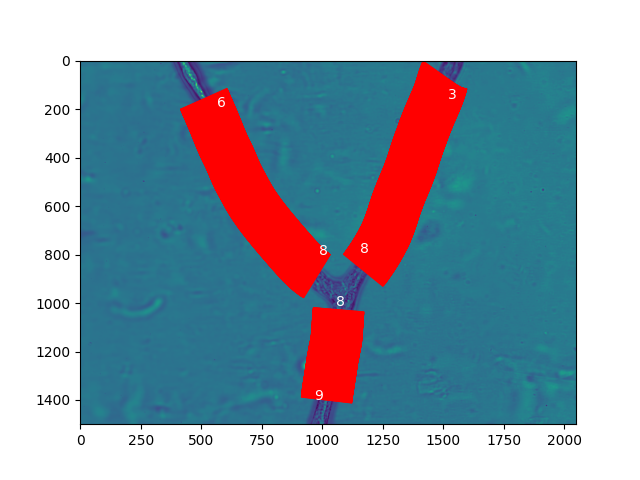

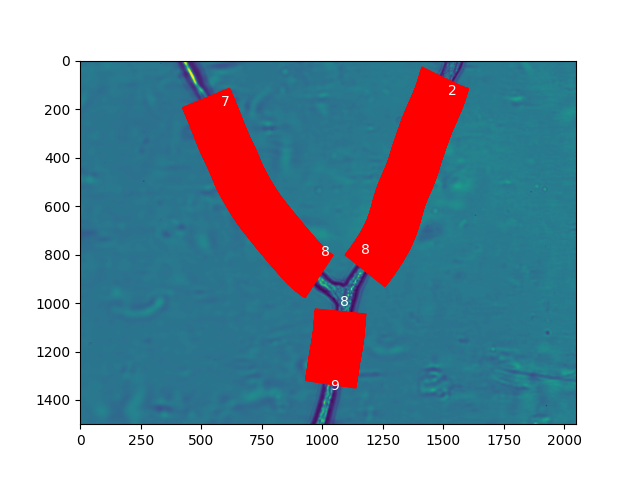

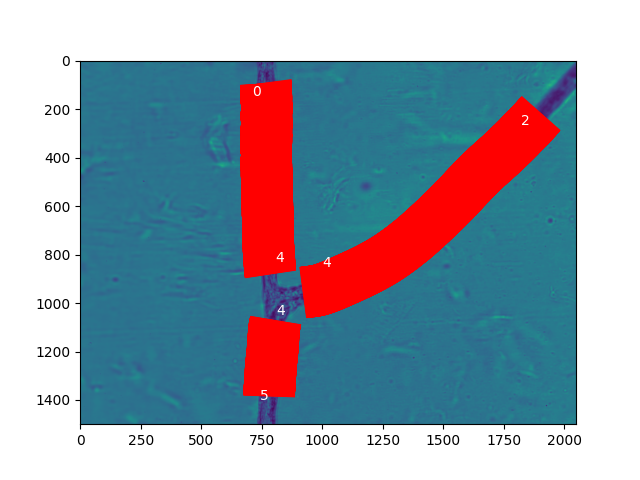

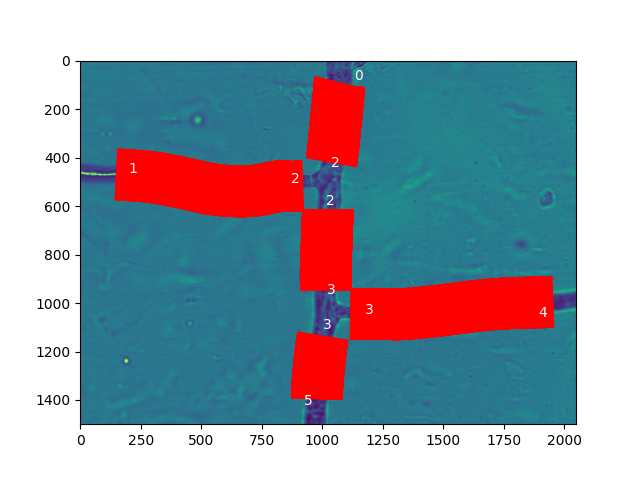

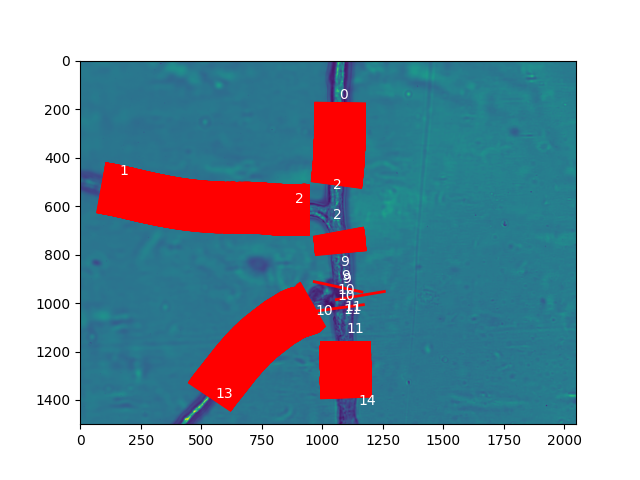

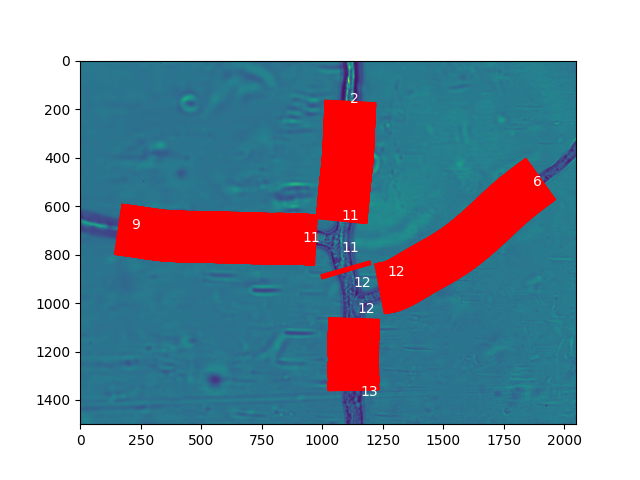

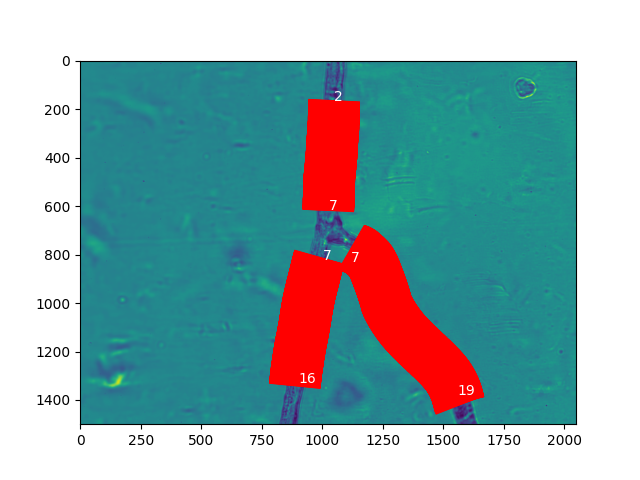

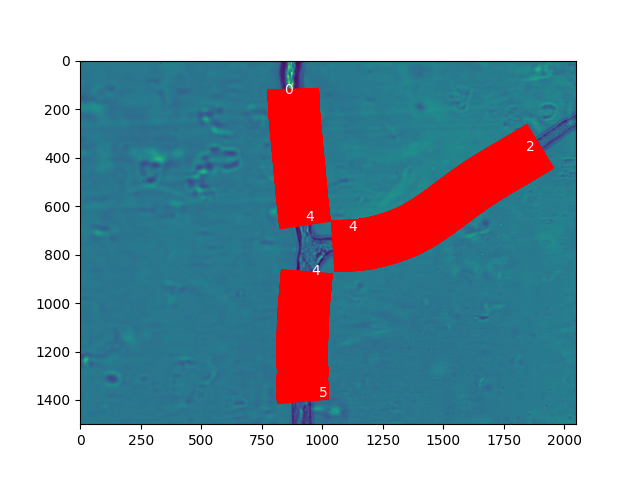

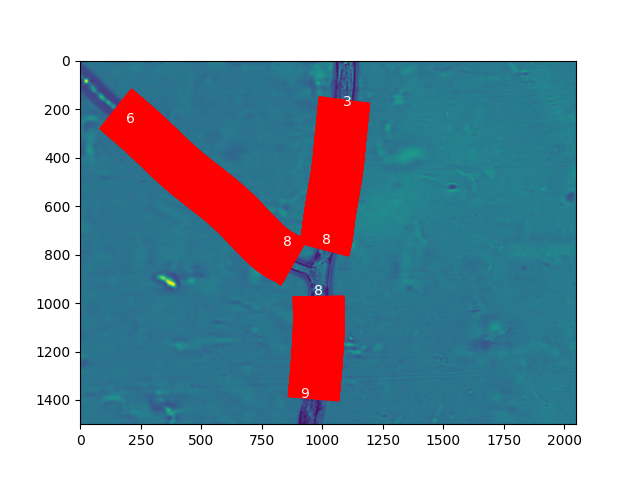

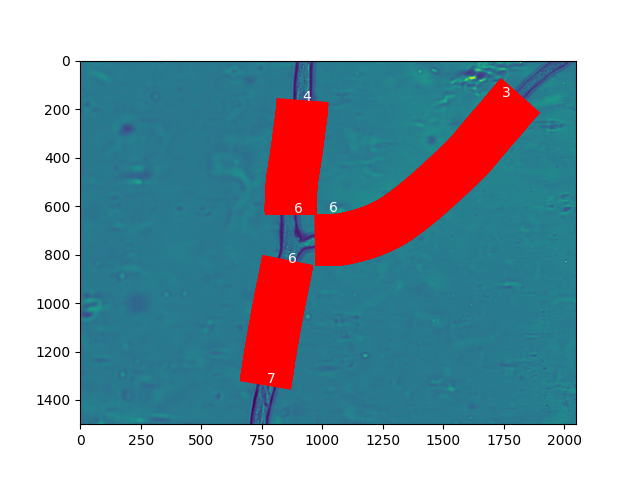

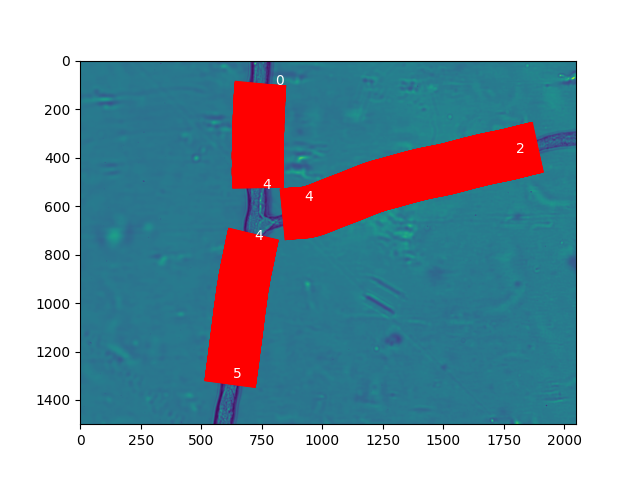

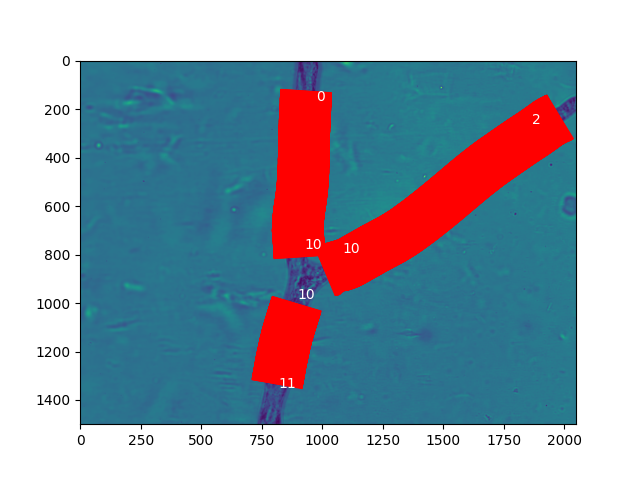

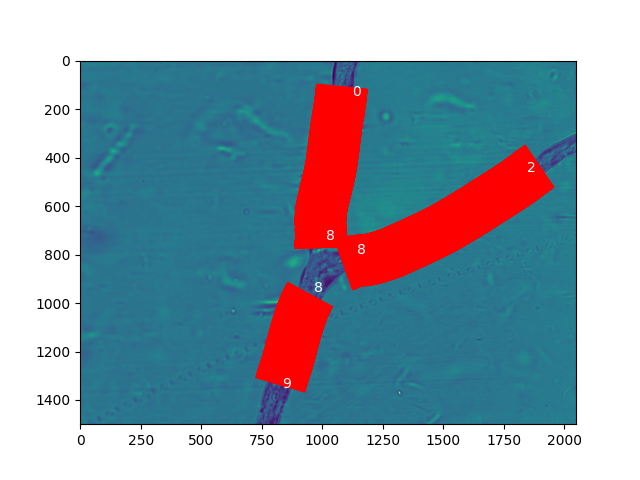

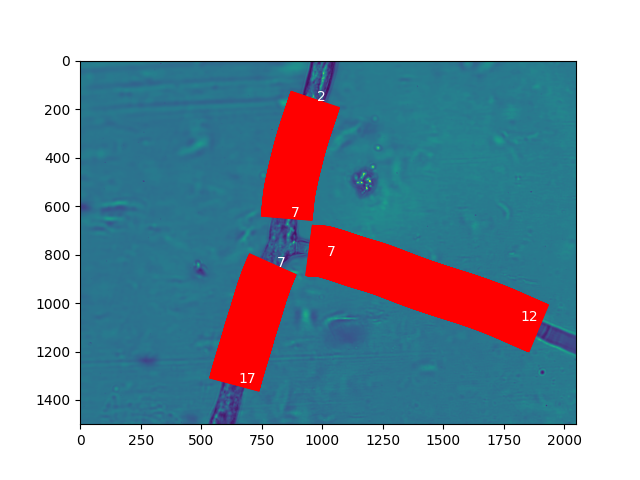

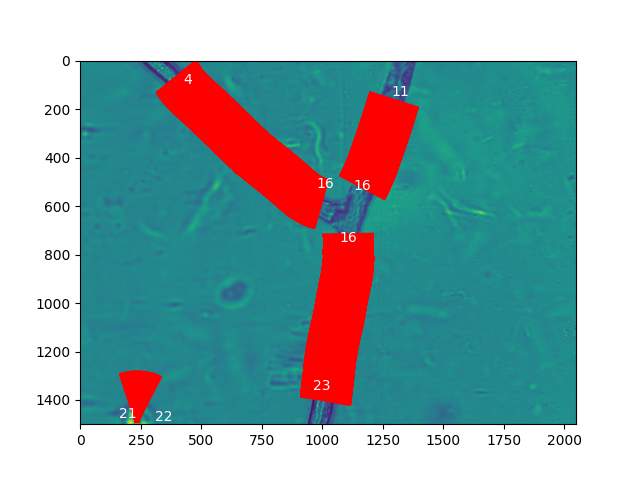

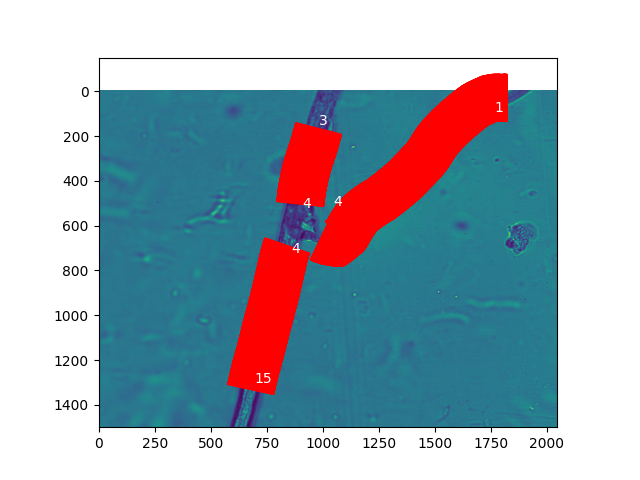

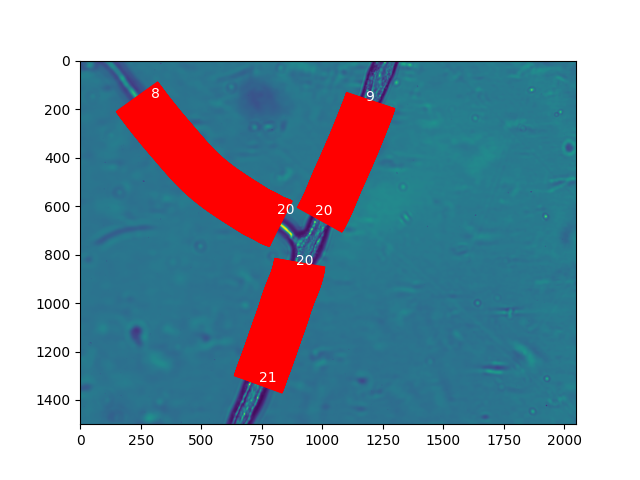

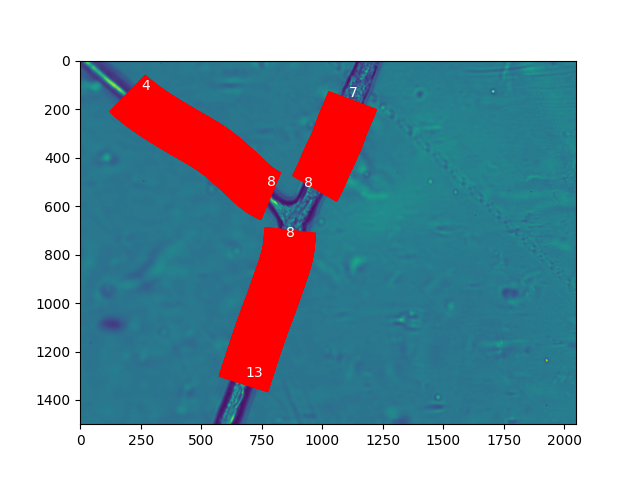

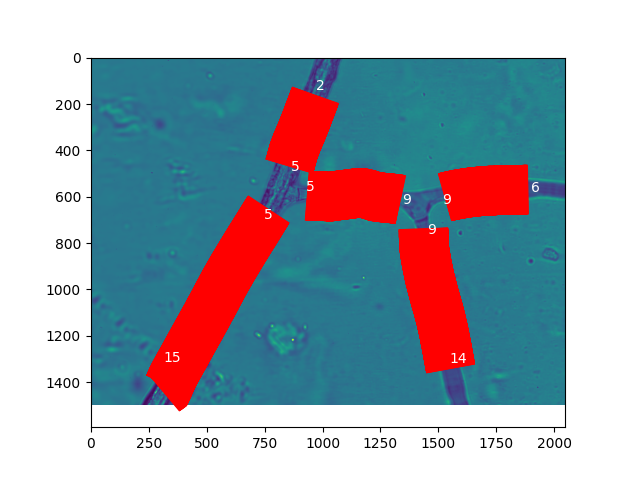

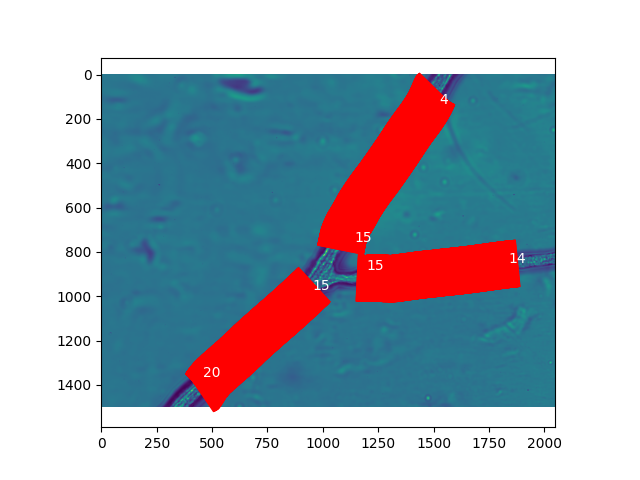

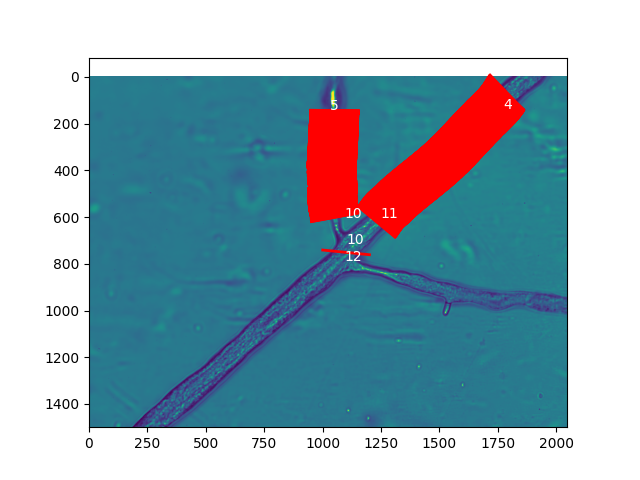

In [4]:
selection_file = images_total_path
selection_file.sort()
for begin in range(1,len(selection_file)):
    image = imageio.imread(selection_file[begin])
    segmented,nx_graph_pruned,pos = segment_brightfield(image)
    edges = list(nx_graph_pruned.edges)
    fig, ax = plt.subplots()
    ax.imshow(image)
    bound1 = 0
    bound2 = 1
    offset=100
    step=30
    target_length=200
    resolution = 1
    weight = 0.15
    for edge in edges:
        slices, segments = extract_section_profiles_for_edge(
        edge,
        pos,
        image,
        nx_graph_pruned,
        resolution=resolution,
        offset=offset,
        step=step,
        target_length=target_length,
        bound1=bound1,
        bound2=bound2
    )
        ax.text(*np.flip((1-weight) * pos[edge[0]]+weight*pos[edge[1]]),str(edge[0]),color="white")
        ax.text(*np.flip((1-weight) * pos[edge[1]]+weight*pos[edge[0]]),str(edge[1]),color="white")
        plot_segments_on_image(segments, ax)


In [5]:
select_exp = "/home/ipausers/lin/Desktop/Graduation/Kai/Graduation-Project/Experiment/Labelme/Fluorescence_ex_Kai-kai_Plate705.xlsx"
exp_df = pd.read_excel(select_exp,engine = "openpyxl",sheet_name="11.16",skiprows=1,index_col=0,header=0)
segment = get_labelme_segments("/home/ipausers/lin/Desktop/Graduation/Kai/Graduation-Project/Experiment/Labelme/Plate705_20221116/")
width_dict,width_std_dict= compute_width_from_segment(segment)
labelme_df = pd.DataFrame.from_dict(width_dict,orient='index')
labelme_df = labelme_df.sort_index()
for index, value in labelme_df.iterrows():
    if len(index.split("_")) == 2:
        pos, direction = index.split("_")
        exp_df.at[pos.lower(),direction]=value[0]
    if len(index.split("_")) == 3:
        pos, direction,direction2 = index.split("_")
        exp_df.at[pos.lower(),direction+direction2]=value[0]
exp_df = exp_df.iloc[:,9:]
exp_df["new_index"] = exp_df.index
exp_df["new_index"] = np.where(exp_df["new_index"].str.len() <=4, exp_df["new_index"].str.slice(stop=3)+"0"+exp_df["new_index"].str.slice(start=3), exp_df["new_index"])
exp_df = exp_df.set_index("new_index")
select_exp = "/home/ipausers/lin/Desktop/Graduation/Kai/Graduation-Project/Experiment/Labelme/Fluorescence_ex_Kai-kai_Plate705.xlsx"
ML_df = pd.read_excel(select_exp,engine = "openpyxl",sheet_name="50X_ML",index_col=0,header=0)

In [6]:
images_path = r"/mnt/sun/shimizu-data/home-folder/Kaikai/Plate705_161122"
binning = 1
magnification = 50
space_pixel_size = 2*1.725/(magnification)*binning
files = os.listdir(images_path)
images_total_path = [os.path.join(images_path,file) for file in files]
selection_file = images_total_path
selection_file.sort()

In [ ]:
order_label = ["order_1","order_2","order_3","order_4"]
for begin in range(len(selection_file)):
    file_name = selection_file[begin].split('/')[-1].split('.')[0]
    try:
        row = exp_df.loc[file_name].dropna()
        if len(row) <= 3:
            print(f"Loading {file_name} now")
            image = imageio.imread(selection_file[begin])
            fig, ax = plt.subplots()
            ax.imshow(image)
            segmented, nx_graph_pruned, pos = segment_brightfield(image)
            edges = list(nx_graph_pruned.edges)
            bound1, bound2, offset,step, resolution,weight= 0, 1, 100, 30, 1, 0.15
            target_length = 200
            count = 0
            for edge in edges:
                position = ML_df.loc[file_name][order_label[count]]
                width = exp_df.loc[file_name][position]
                count+=1
                slices, segments = extract_section_profiles_for_edge(
                edge,
                pos,
                image,
                nx_graph_pruned,
                resolution=resolution,
                offset=offset,
                step=step,
                target_length=target_length,
                bound1=bound1,
                bound2=bound2)
                slices = slices[len(slices)//4:-len(slices)//4]
                segments = segments[len(segments)//4:-len(segments)//4]
                ax.text(*np.flip((1-weight) * pos[edge[0]]+weight*pos[edge[1]]),str(edge[0]),color="white")
                ax.text(*np.flip((1-weight) * pos[edge[1]]+weight*pos[edge[0]]),str(edge[1]),color="white")
                plot_segments_on_image(segments, ax)
    except KeyError:
        print(f'The file {file_name} will not be extract.')

The file pos01_focus1 will not be extract.
The file pos01_focus2 will not be extract.
The file pos01_focus3 will not be extract.
Loading pos02 now


/tmp/ipykernel_3868298/3184618208.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)
